In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [17]:
kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [2]:
pm_poly = np.load('../../gd1-dr2/output/pm_poly.npy')

In [3]:
w = np.load('../../gd1-dr2/data/stream_model.npy')
stream_w = gd.PhaseSpacePosition(pos=w[:, :3].T*u.kpc,
                                 vel=w[:, 3:].T*u.km/u.s)
model_c = stream_w.to_coord_frame(gc.GD1)
model_c = model_c[(model_c.phi1.wrap_at(180*u.deg) < 20*u.deg) & 
                  (model_c.phi1.wrap_at(180*u.deg) > -100*u.deg)]
model_c_ref = gc.reflex_correct(model_c)

In [4]:
gd1_g = GaiaData('../../gd1-dr2/data/gd1-master.fits')

In [6]:
apogee_gaia = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')

In [7]:
stream_mask = (apogee_gaia['APOGEE2_TARGET1'] & (2**18 + 2**19)) != 0
stream_mask.sum()

1026

In [8]:
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]

# select distant stuff
apogee_gaia = apogee_gaia[apogee_gaia['parallax'] < 1.]

g = GaiaData(apogee_gaia)
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


231808

In [9]:
gd1_mask = np.array(['GD1' in f for f in apogee_gaia['FIELD']])
gd1_mask.sum()

1153

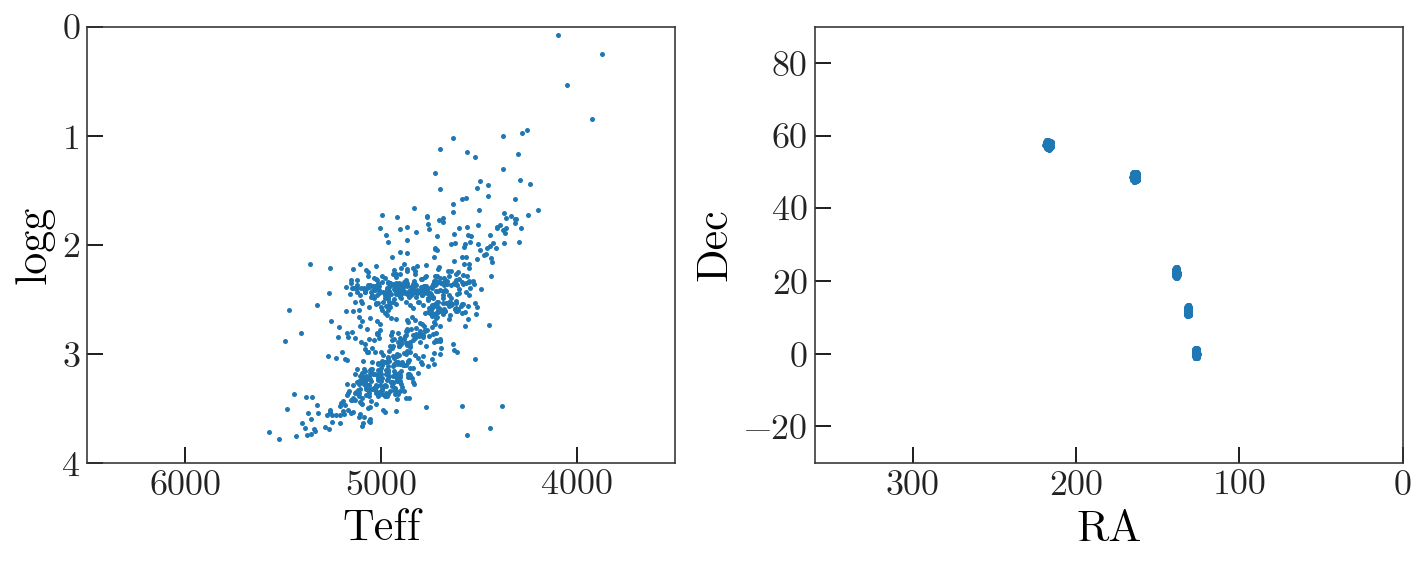

In [10]:
mask = gd1_mask

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.plot(apogee_gaia['TEFF'][mask], apogee_gaia['LOGG'][mask], 
        marker='.', linestyle='none')
ax.set_xlabel('Teff')

ax.set_xlim(6500, 3500)
ax.set_ylim(4, 0)
ax.set_ylabel('logg')

ax = axes[1]
ax.plot(apogee_gaia['RA'][mask], apogee_gaia['DEC'][mask], 
        marker='.', linestyle='none')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_xlim(360, 0)
ax.set_ylim(-30, 90)

fig.tight_layout()

In [11]:
c = g.get_skycoord(distance=8*u.kpc, 
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
c = gc.reflex_correct(c.transform_to(gc.GD1))

phi1 = c.phi1.wrap_at(180*u.deg)
phi2 = c.phi2

pm1 = c.pm_phi1_cosphi2.to(u.mas/u.yr)
pm2 = c.pm_phi2.to(u.mas/u.yr)

In [12]:
gd1_c = gd1_g[gd1_g.gi_cmd_mask & gd1_g.pm_mask].get_skycoord(distance=False)
gd1_c = gd1_c.transform_to(gc.GD1)

gd1_phi1 = gd1_c.phi1.wrap_at(180*u.deg)
gd1_phi2 = gd1_c.phi2
gd1_pm1 = gd1_c.pm_phi1_cosphi2.to(u.mas/u.yr)
gd1_pm2 = gd1_c.pm_phi2.to(u.mas/u.yr)

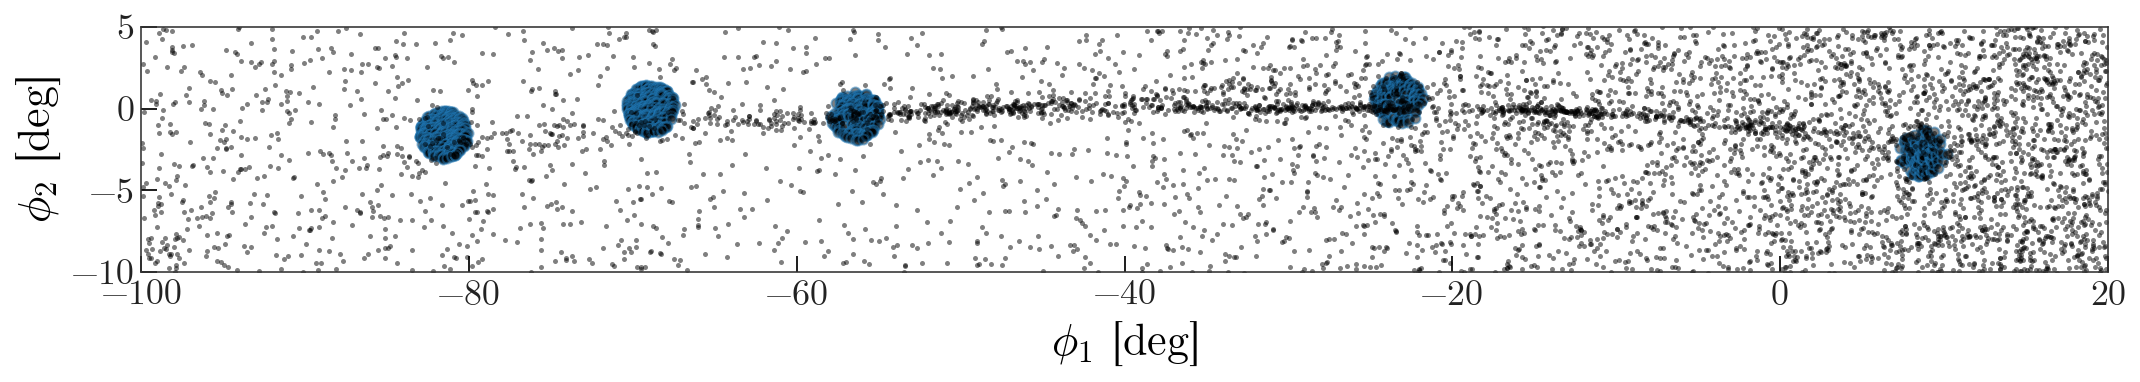

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(phi1[gd1_mask], phi2[gd1_mask], 
        marker='o', mec='tab:blue', mew=1, mfc='none',
        ls='none', alpha=0.5)

ax.plot(gd1_phi1, gd1_phi2, 
        marker='.', ls='none', alpha=0.5, color='k')

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

fig.tight_layout()
fig.savefig('../plots/gd-1/full-phi1phi2.png', dpi=250)

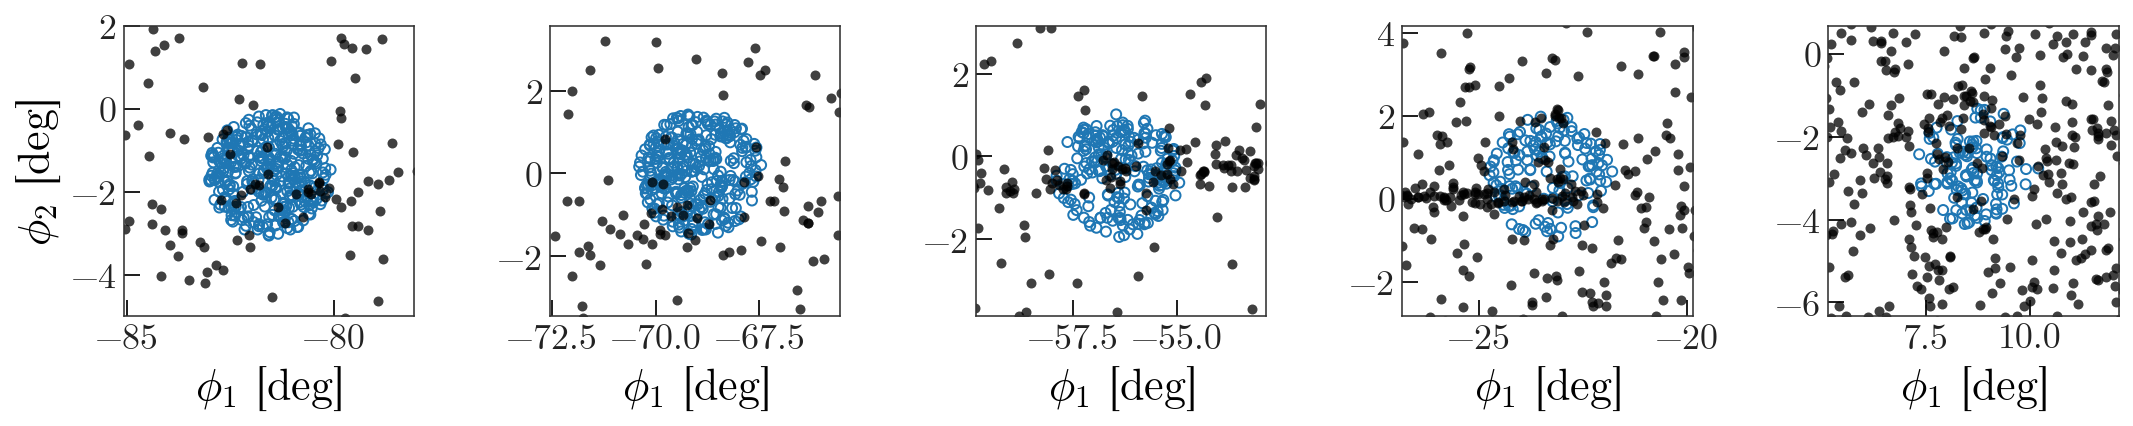

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, field_name in enumerate(np.unique(apogee_gaia['FIELD'][gd1_mask])):
    ax = axes[i]
    
    field_mask = apogee_gaia['FIELD'] == field_name

    _phi1 = phi1[gd1_mask & field_mask].value
    _phi2 = phi2[gd1_mask & field_mask].value
    
    ax.scatter(phi1[gd1_mask], phi2[gd1_mask], 
               marker='o', color='tab:blue', linewidth=1, facecolor='none',
               alpha=1, s=25)

    ax.plot(gd1_phi1, gd1_phi2, 
            marker='o', ls='none', alpha=0.75, color='k')

    ax.set_xlim(np.mean(_phi1) - 3.5, 
                np.mean(_phi1) + 3.5)
    ax.set_ylim(np.mean(_phi2) - 3.5, 
                np.mean(_phi2) + 3.5)
    ax.set_aspect('equal')
    
    ax.set_xlabel(r'$\phi_1$ [deg]')

    fig.tight_layout()
    
axes[0].set_ylabel(r'$\phi_2$ [deg]')

fig.savefig('../plots/gd-1/zoom-phi1phi2.png', dpi=200)

In [46]:
apogee_pm_mask = pm_path.contains_points(np.vstack((pm1, pm2)).T)
apogee_pm_mask.sum(), (gd1_mask & apogee_pm_mask).sum()

(4122, 23)

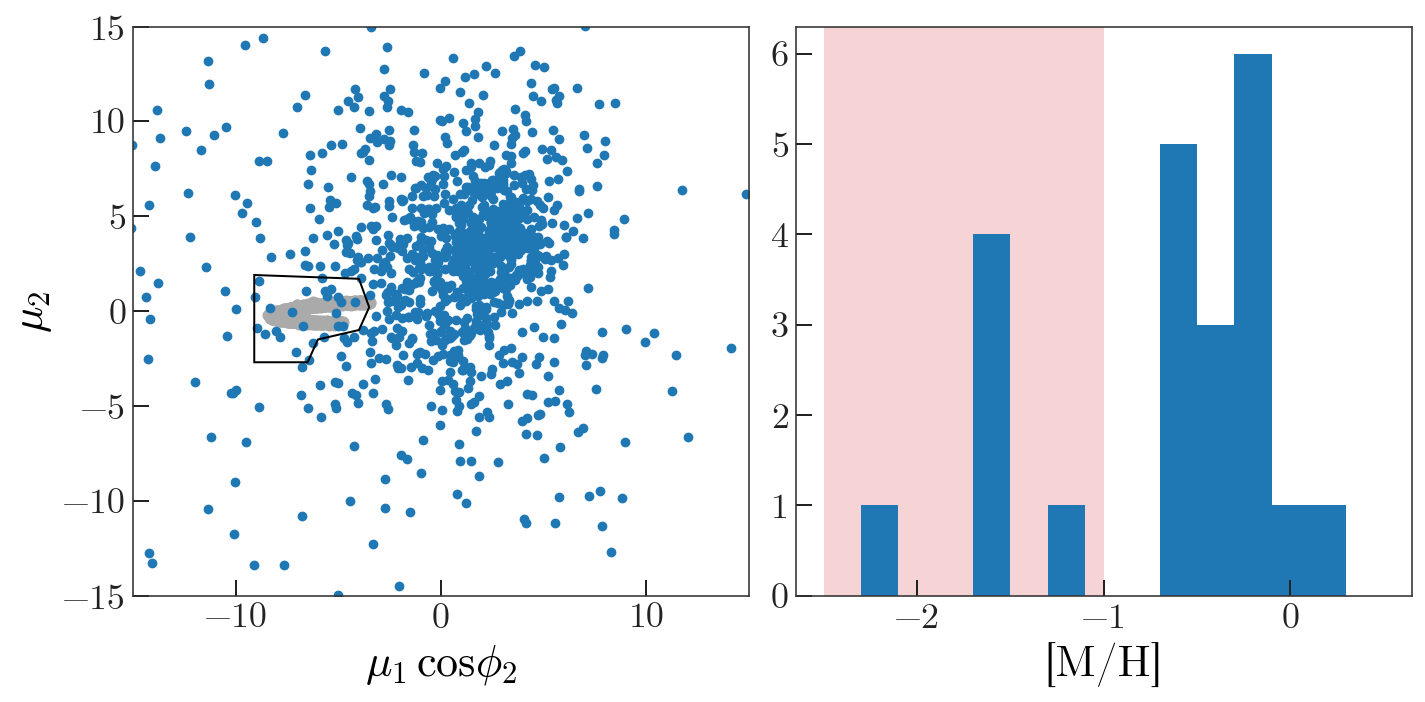

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(pm1[gd1_mask], pm2[gd1_mask], marker='o', color='tab:blue', 
           linewidth=1, s=15, alpha=1)

pm_path = mpl.patches.Polygon(pm_poly, 
                              facecolor='none', edgecolor='k')
ax.add_patch(pm_path)
pm_path = mpl.patches.Path(pm_poly)

ax.scatter(model_c_ref.pm_phi1_cosphi2.to(u.mas/u.yr), 
           model_c_ref.pm_phi2.to(u.mas/u.yr), 
           zorder=-100, color='#aaaaaa')

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

ax.set_xlabel(r'$\mu_1 \, \cos\phi_2$')
ax.set_ylabel(r'$\mu_2$')


ax = axes[1]
ax.hist(g.M_H[gd1_mask & apogee_pm_mask], bins=np.linspace(-2.5, 0.5, 16));
ax.axvspan(-2.5, -1, zorder=-10, color='tab:red', 
           alpha=0.2, linewidth=0)
ax.set_xlabel('[M/H]')


fig.tight_layout()
fig.savefig('../plots/gd-1/pm-feh.png', dpi=250)

In [26]:
gd1_feh_mask = (g.M_H < -1.) & (g.M_H > -2.5)

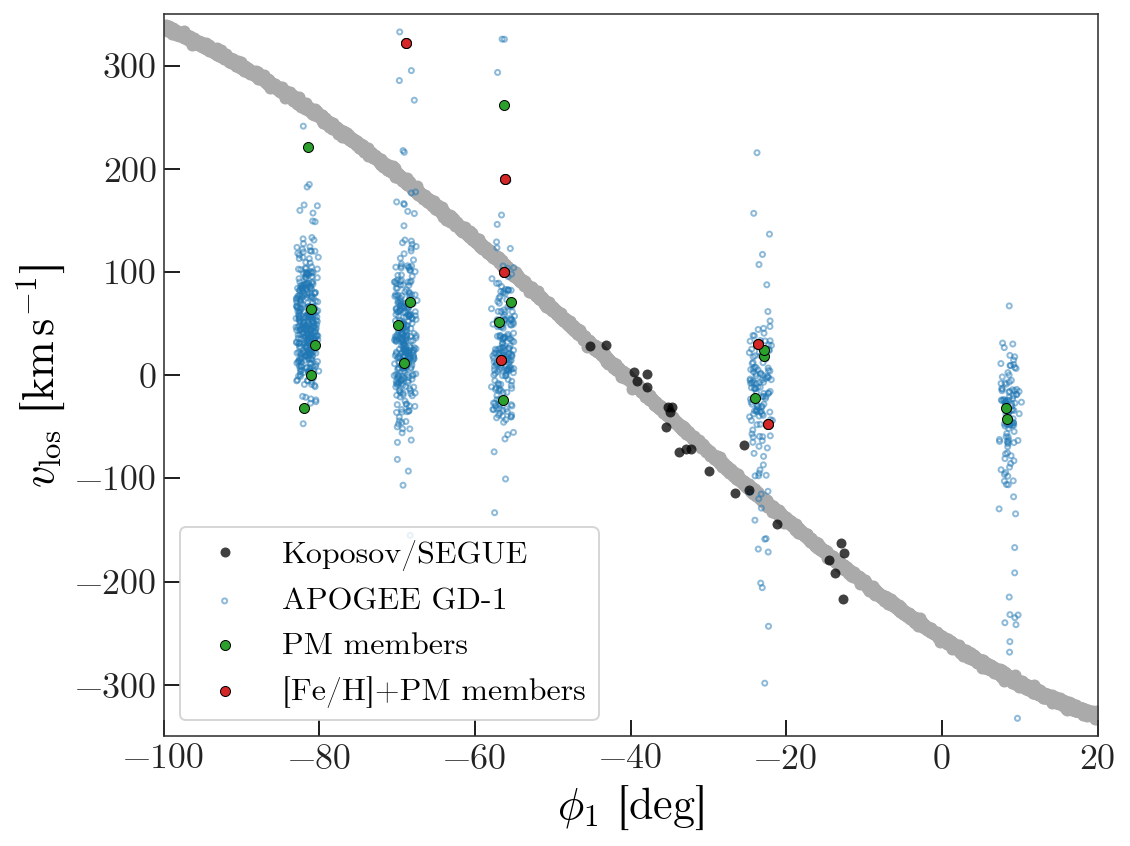

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(phi1.value[gd1_mask],
           g.VHELIO_AVG[gd1_mask], 
           marker='.', color='tab:blue', linewidth=1, facecolor='none',
           alpha=0.5, s=25, label='APOGEE GD-1')

ax.scatter(phi1.value[gd1_mask & apogee_pm_mask],
           g.VHELIO_AVG[gd1_mask & apogee_pm_mask], 
           color='tab:green', label='PM members', 
           linewidth=0.5, edgecolor='k')

ax.scatter(phi1.value[gd1_mask & apogee_pm_mask & gd1_feh_mask],
           g.VHELIO_AVG[gd1_mask & apogee_pm_mask & gd1_feh_mask], 
           color='tab:red', label='[Fe/H]+PM members',
           linewidth=0.5, edgecolor='k')

ax.plot(kop_vr['phi1'], kop_vr['vr'], 
        marker='o', ls='none', alpha=0.75, color='k', 
        label='Koposov/SEGUE')

ax.scatter(model_c.phi1.wrap_at(180*u.deg),
           model_c.radial_velocity.to(u.km/u.s), 
           zorder=-100, color='#aaaaaa')
#           label='model')

ax.set_xlim(-100, 20)
ax.set_ylim(-350, 350)

ax.set_xlabel(r'$\phi_1$ [deg]')

ax.legend(loc='lower left', fontsize=16)
ax.set_ylabel(r'$v_{\rm los}$' + ' [{0:latex_inline}]'.format(u.km/u.s))
fig.tight_layout()
fig.savefig('../plots/gd-1/rv.png', dpi=250)

In [76]:
rv_clump_mask = (phi1.value > 0) & (phi1.value < 20) & (g.VHELIO_AVG < -200) & (g.VHELIO_AVG > -300)
(gd1_mask & rv_clump_mask).sum()

8

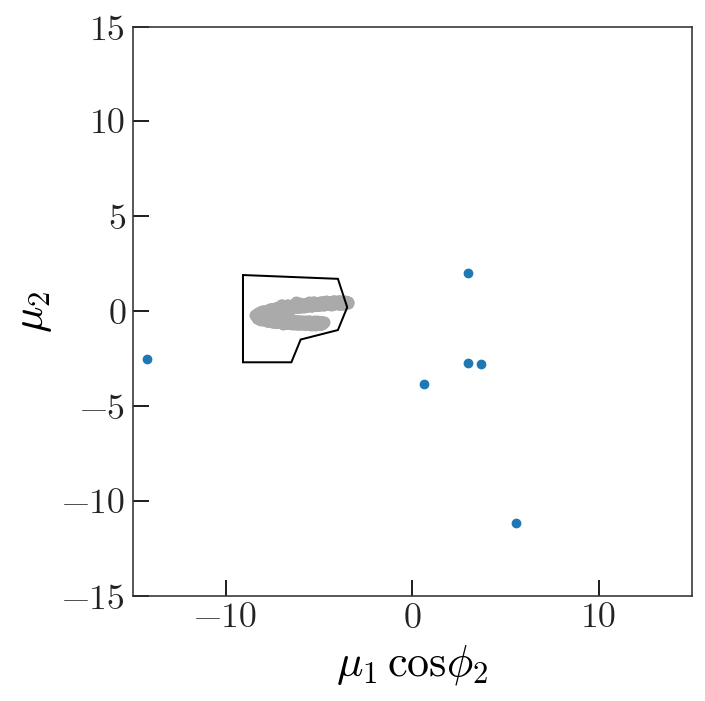

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(pm1[gd1_mask & rv_clump_mask], pm2[gd1_mask & rv_clump_mask], 
           marker='o', color='tab:blue', 
           linewidth=1, s=15, alpha=1)

pm_path = mpl.patches.Polygon(pm_poly, 
                              facecolor='none', edgecolor='k')
ax.add_patch(pm_path)
pm_path = mpl.patches.Path(pm_poly)

ax.scatter(model_c_ref.pm_phi1_cosphi2.to(u.mas/u.yr), 
           model_c_ref.pm_phi2.to(u.mas/u.yr), 
           zorder=-100, color='#aaaaaa')

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

ax.set_xlabel(r'$\mu_1 \, \cos\phi_2$')
ax.set_ylabel(r'$\mu_2$')
fig.tight_layout()
fig.savefig('../plots/gd-1/rv-clump.png', dpi=250)

Text(0,0.5,'[Al/Fe]')

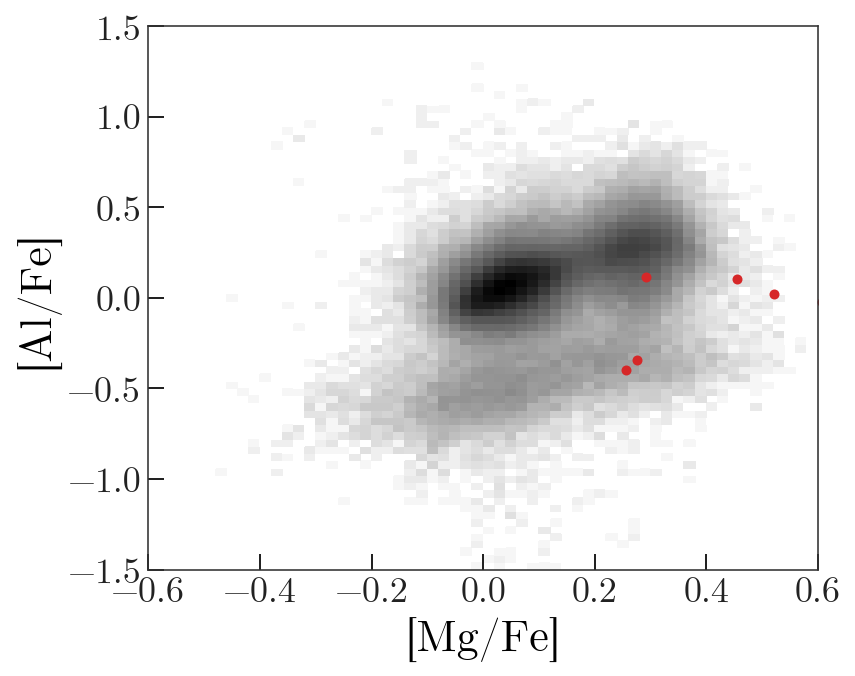

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# H, xe, ye = np.histogram2d(g.M_H, mg_al, 
#                            bins=(np.arange(-2.5, 0.5+1e-3, 0.2),
#                                  np.arange(-2, 2+1e-3, 0.2)))
H, xe, ye = np.histogram2d(g.MG_FE, g.AL_FE,
                           bins=(np.arange(-0.6, 0.6+1e-3, 0.02),
                                 np.arange(-1.5, 1.5+1e-3, 0.04)))

ax.pcolormesh(xe, ye, H.T, 
              norm=mpl.colors.LogNorm(), cmap='Greys')

ax.plot(g.MG_FE[gd1_mask & apogee_pm_mask & gd1_feh_mask],
        g.AL_FE[gd1_mask & apogee_pm_mask & gd1_feh_mask], 
        ls='none', marker='o', alpha=1, color='tab:red')

ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-1.5, 1.5)

ax.set_xlabel('[Mg/Fe]')
ax.set_ylabel('[Al/Fe]')